# SPIKING DATA GENERATOR

## Generates the files (output spikes) necessary to train the readouts.

### What can I vary in this setup?
1. Total number of neurons (depends on net_shape and is automatically calculated by the simulator)
2. Input code (3D, 2D and the old 2D used in my RDC2 simulations)
3. Number of possible input values or resolution (Ninput), but it must comply with the total number of neurons...
4. Simulation time step size
5. Liquid's shape (net_shape)
6. Liquid's connections density (lbd_value)
7. Liquid's internal parameters (parameter_list), so far I've been using Maass2002 and Joshi/Maass2005
8. Neuron's parameters (membrane_rand, current_rand, noisy_current_rand and SpkLiq_vresets_rand)
9. Random seeds for liquid's structure
10. Base value used for the input code gain (input_gain)
11. Spread of the generated input code (w_SD)
12. Number of trials used for the readout training
13. Amount of noise inject into the inputs during training

Every simulation uses the initial random neuron parameters as membrane, offset current and reset threshold.  
Also the weights are randomly chosen at the start. Maybe everytime a simulation is done, one possible learn pattern will occur.

# Baxter REAL joint ranges
range_s0=-2.461,3.351  
range_s1=-2.147,3.194  
range_e1=-0.052,2.67  
range_w1=-1.571,3.665  

In [1]:
# This is not working on Linux because I'm getting an error whilst compiling the shared library 
import sys
from BEE import *

In [2]:
# Makes possible to show the output from matplotlib inline
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib 

# Makes the figures in the PNG format:
# For more information see %config InlineBackend
%config InlineBackend.figure_formats=set([u'png'])

# plt.rcParams['figure.figsize'] = 5, 10 # redefines the figure's default size

import numpy

import save_load_file as slf

In [3]:
#
# Controls if the results are saved to a file
#

save2file = False

# Initialization and functions necessary to all the liquids

In [87]:
sim_set = "triangle" # basically is the name of the folder (shape) where the data is read/saved
base_dir = "BaxterArm_VREP_simulation_data"

In [88]:
# This data must follow what was used to generate the trajectories
# or the arm model will behave differently!

# Total time spent during the movement (in seconds)
MT = 2.0

# Simulation time step (in seconds)
time_step = 2/1000.0

total_steps = int(MT/time_step)

In [89]:
# S0, S1, E1 and W1 are the Baxter's joint names
# Four joints => four input variables
Number_of_input_variables=4 # defines how the liquid is going to be divided to receive the inputs

In [90]:
#
# Number of neurons at each input layer (defines the INPUT resolution of the system)
#
# >>>>>>>>> It MUST be smaller or equal to (NofN/Number_of_input_variables) <<<<<<<<<<<
#
Ninput = 150

In [91]:
# Loads the joint angles saved by the V-REP simulated BAXTER
original_joints=numpy.zeros((0,4)) #creates an empty array with the right shape...

temp=numpy.load(base_dir+"/"+sim_set+"/XY_movement_"+sim_set+".npy")
original_joints=numpy.concatenate((original_joints,temp[:1000]))

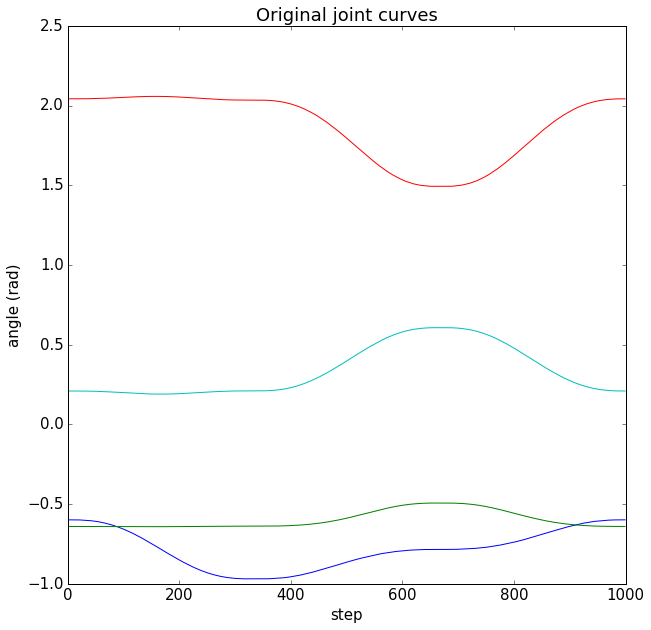

In [92]:
plt.figure(figsize=(10,10))
plt.plot(original_joints)
plt.title("Original joint curves")
plt.ylabel("angle (rad)")
plt.xlabel("step")
plt.xlim(0,1000)
plt.show()

In [93]:
def generates_input_spikes_lsm(number_of_steps=total_steps, \
                               neurons_per_layer=Ninput, \
                               number_of_joints=Number_of_input_variables, \
                               joints_all=numpy.copy(original_joints)):
        
    
    # Creates the Ninput possible discrete values of angle for each joint
    # Because the normalisation all joints are ALWAYS between -1 and 1
    joints_values_normalized=numpy.empty((neurons_per_layer,number_of_joints))
    for ji in range(number_of_joints):
        joints_values_normalized[:,ji]=numpy.linspace(-1,1,neurons_per_layer)
        
    # HERE SEEMS TO BE THE ONLY PLACE I COULD INJECT AN "ANALOG" NOISE INTO THE INPUTS.
    

    # Signal conditioning
    temp_s0=joints_all[:,0]-joints_all[0,0] # Extracts the bias (first value)
    s0_range=(temp_s0.max()-temp_s0.min()) #calculates the range after extracting the bias
    temp_s0=temp_s0/float(s0_range) #normalizes making the biggest value: abs(value)=1

    temp_s1=joints_all[:,1]-joints_all[0,1]
    s1_range=(temp_s1.max()-temp_s1.min())
    temp_s1=temp_s1/float(s1_range)

    temp_e1=joints_all[:,2]-joints_all[0,2]
    e1_range=(temp_e1.max()-temp_e1.min())
    temp_e1=temp_e1/float(e1_range)

    temp_w1=joints_all[:,3]-joints_all[0,3]
    w1_range=(temp_w1.max()-temp_w1.min())
    temp_w1=temp_w1/float(w1_range)


    joints_normalized_idx = numpy.empty((number_of_steps,number_of_joints),dtype=numpy.int)

    for i,jnt in zip(range(number_of_joints),[temp_s0,temp_s1,temp_e1,temp_w1]):
        joints_normalized_idx[:,i]=numpy.array([abs(joints_values_normalized[:,i]-j).argmin() for j in jnt])
        
    joint_s0 = joints_normalized_idx[:,0]
    joint_s1 = joints_normalized_idx[:,1]
    joint_e1 = joints_normalized_idx[:,2]
    joint_w1 = joints_normalized_idx[:,3]

        
    return (joint_s0,joint_s1,joint_e1,joint_w1)

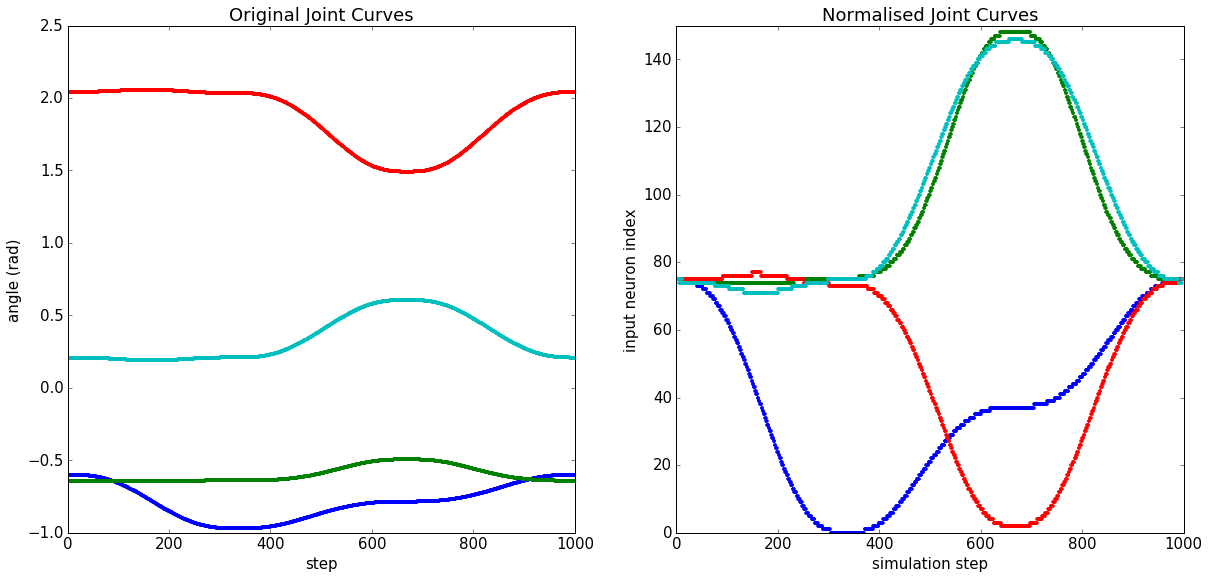

In [94]:
# TESTING THE NEW INPUT CODE

joint_s0,joint_s1,joint_e1,joint_w1 = generates_input_spikes_lsm()

v = joint_s0,joint_s1,joint_e1,joint_w1

font = {'weight' : 'normal',
        'size'   : 15}

matplotlib.rc('font', **font)

plt.figure(figsize=(20,20))

plt.subplot(221)
plt.plot(original_joints ,'.')
plt.title("Original Joint Curves")
plt.ylabel("angle (rad)")
plt.xlabel("step")

plt.subplot(222)
for vi,ji in zip(v,['s0','s1','e1','w1']):
    plt.plot(vi,'.', label="joint "+ji)
plt.title("Normalised Joint Curves")
plt.ylabel("input neuron index")
plt.xlabel("simulation step")
plt.ylim(0,Ninput)
if save2file:
    plt.savefig(base_dir+"/"+sim_set+"/example_input_norm.pdf", bbox_inches='tight',pad_inches=.1)
plt.show()

# Configuring the liquid:

In [95]:
# 
# Defines how many liquids
# 
number_of_liquids = 5



liqseeds = []
for i in range(number_of_liquids):
    liqseeds.append(numpy.array(numpy.random.randint(0,10000,6),dtype=numpy.uint32))
    
#
# Comment the next line to generate NEW seeds
#
liqseeds=slf.load_from_file_gz(base_dir+"/"+sim_set+"/"+"liqseeds.gzpickle")    

In [96]:
# Uncomment the next two lines to save the NEW seeds:
# if save2file:
#     slf.save_to_file_gz(liqseeds,"./"+base_dir+"/"+sim_set+"/"+"liqseeds.gzpickle")

for i in range(number_of_liquids):
    print "Liquid %d:" % i, liqseeds[i]

Liquid 0: [1604 4865 5606  394 3298 3443]
Liquid 1: [7526 7407 4280 6879 2611 3823]
Liquid 2: [1279 9653 5715 3570 4335 5555]
Liquid 3: [6101 8256 9372 2739 1444 5597]
Liquid 4: [3496 5715 5436 4689 7052 9634]


# Simulations with different liquids start here!
## It needs to be repeated from lsm_i = 0 up to (number_of_liquids-1)

In [97]:
#
# Here the liquid index is defined
#
# REMEMBER: it goes from ZERO to number_of_liquids-1

lsm_i = 0


#
# Liquid's shape
#

# Liquid's shape
net_shape = numpy.array([20,5,6])

# Random seeds:
# // RANDOM-1: Noisy offset currents / resets
# // RANDOM-2: Selection of the inhibitory and excitatory neurons
# // RANDOM-3: Internal connections of the liquid
RANDOM_1=liqseeds[lsm_i][1]
RANDOM_2=liqseeds[lsm_i][2]
RANDOM_3=liqseeds[lsm_i][3]
#DEBUG!
# RANDOM_4=8337
# RANDOM_0=5751

RANDOM_input=liqseeds[lsm_i][5] # input gaussian noise

input_noise_std = 1 # Standard deviation of the input gaussian noise

# Neuron parameters
taum=0.03 # membrane time constant
cm=3e-08 # membrane capacitance
taue=0.003 # excitatory synapse time constant
taui=0.006 # inhibitory synapse time constant


# The "current_rand" noise source is the problematic one. Because it has a mean value different from
# zero, it generates a new liquid every run as the neuron models change according to the offset current "current_rand".

# Maass noisy sources
# membrane_rand=[0.0135, 0.015] # mean value 13.75E-3, uniform distribution, max value equal to threshold (15mV).
# current_rand=[14.975e-09, 15.025e-09] # mean value 15E-9, uniform distribution.
# noisy_current_rand=2e-10 # normal distribution, mean zero.


# Parameters paper Joshi/Maass
membrane_rand=[13.5E-3,14.9E-3] # mean value 13.7E-3, uniform distribution, max value below threshold (15mV).
current_rand=[13.5E-09, 14.5E-09] # mean value 14E-9, uniform distribution.
noisy_current_rand=1E-9 # normal distribution, mean zero.

factor=2*10.0

SpkLiq_vresets_rand=[13.8E-3,13.8E-3*(1+1/factor)] # the membrane reset values are drawn from a uniform distribution


lbd_value = 1.2 

# Controls if the neurons are connected to each other (basically ignores the distance based connection probability)
disconnected = False

parameter_list=\
[[[0.1  ,  0.32 ,  0.144,  0.06 ,  -47.  ,  0.8],\
  [0.4  ,  0.25 ,  0.7  ,  0.02 ,  -47  ,  0.8]],\
 [[0.2  ,  0.05 ,  0.125,  1.2  ,  150  ,  0.8],\
  [0.3  ,  0.5  ,  1.1  ,  0.05 ,  70  ,  1.5]]]

# parameter_list = [] # Maass parameters change only the gains (nA): 1.2 (EE), 1.6 (EI), -3.0 (IE), -2.8 (II)
                    # instead of -47,-47,150,70

input_gain=105. # gain used for the input neurons
w_SD = 3.0 # input neurons standard deviation


#
# END OF THE SETUP - everything that should change between liquids is expressed above...
#


#
# This first initialization of the simulator is only used to generate the liquid structure's data
#

# Resets the simulator
BEE_free()

tstp = time_step

seeds=numpy.array(numpy.random.randint(0,10000,5),dtype=numpy.uint32)
# // RANDOM-0: Membrane initial potentials
# // RANDOM-1: Noisy offset currents / resets
# // RANDOM-2: Selection of the inhibitory and excitatory neurons
# // RANDOM-3: Internal connections of the liquid
# // RANDOM-4: Noisy corrents
seeds[1] = RANDOM_1
seeds[2] = RANDOM_2
seeds[3] = RANDOM_3

input_noise_seed = RANDOM_input

if not BEE_initialized():
    initialize_sim(my_net_shape = net_shape, \
                   my_lbd_value = lbd_value, \
                   my_seeds=seeds, \
                   SpkLiq_step=time_step,\
                   SpkLiq_threads_N = 5,\
                   SpkLiq_vresets = SpkLiq_vresets_rand,\
                   SpkLiq_membrane_rand=membrane_rand,\
                   SpkLiq_current_rand=current_rand,\
                   SpkLiq_taum=taum, SpkLiq_cm=cm, SpkLiq_taue=taue, SpkLiq_taui=taui, \
                   SpkLiq_noisy_current_rand=noisy_current_rand)
    

if parameter_list!=[]:
    change_parameters(parameter_list)

if BEE_initialized() and (not BEE_connected()):
    generate_connections()

#
# Cancels the connections (if disconnected==True), but keeps the parameters
#
if disconnected:
    BEE_writes_SpkLiq_inh_connections(0)
    BEE_writes_SpkLiq_exc_connections(0)

if BEE_initialized() and (not BEE_connected()):
    process_connections()

NofN,NoINHN,NoEXCN,NoINHC,NoEXCC=output_stats(stats=0)

# Normally the BEE simulator does NOT updates neurons that have no connections to other neurons.
# The neurons without connections are marked in a special array that can be read from the
# Python function output_connected(NofN).
# Every time the simulator goes through one step it checks if the neurons is marked as connected before
# updating its state variables.

# Disconnects all the neurons (nothing will generate spikes anymore)
# control_connected(numpy.zeros(NofN,dtype=numpy.int32))

# Forces the simulator to calculate the values for all neurons (even the unconnected ones)
# This is important during the tests without connections
control_connected(numpy.ones(NofN,dtype=numpy.int32))


#
# Input converter
# 

# This information is used to define the neurons receiving inputs (excitatory neurons):
inhibitory_index_L = output_inh_indices(NoINHN)
inhibitory_index_L.shape

inhibitory_index_L=[] # input signals through all neurons (not only excitatory ones)

#
# Input pattern generation
# 

Number_of_neurons_lsm = NofN
Number_of_input_layers = Number_of_input_variables
Number_of_neurons_inputs = Ninput



# 
# 2D Gaussian generation
#

# DON'T FORGET I HAVE THE 3D and the flat version of the input code!!!!!!!!
# See: BEE_Simulator_ArmControl_v1_CONNECTION_PATTERN_VISUALIZATION_2D.ipynb

#
# Generates the connection pattern used. In the case below it's a gaussian 
# distributed one based on the connection weights.
#

inputs_indices = [] #inputs_indices[input_variable][ni]
inputs_weights = [] #inputs_weights[input_variable][ni]


def gaussian(lamb,n,nt):
    '''
    Generates a gaussian centered at 'n'
    '''
    return input_gain*numpy.exp(-((nt-n)**2)/(2*(lamb)**2)) #No energy normalization

weight_func = gaussian


liquid_input_layer_size = int(Number_of_neurons_lsm/float(Number_of_input_layers))

# Goes through the liquid to generate the proper connections, 
# but dividing the liquid into the same number of input layers.
# Each input layer only connects to its own slice of the liquid.

centre_positions=numpy.linspace(0,liquid_input_layer_size-1,num=Number_of_neurons_inputs).astype(dtype=numpy.int)

for inp in range(Number_of_input_layers): #goes through the input layers
    temp_i=[]
    temp_w=[]        
    for i,ic in zip(range(inp*Number_of_neurons_inputs,Number_of_neurons_inputs*(inp+1)),\
                    range(Number_of_neurons_inputs)): #goes through the input neurons
        temp_i2 = []
        temp_w2 = []
        for j,ji in zip(range(inp*liquid_input_layer_size,liquid_input_layer_size*(inp+1)),\
                        range(liquid_input_layer_size)):
            if j not in inhibitory_index_L:
                centre_position=centre_positions[ic]
                temp_weight=weight_func(w_SD,centre_position,ji)             
                if temp_weight>0: #guaranties only real spikes will be injected, saving cpu time
                    temp_w2.append(temp_weight) # in nA
                    temp_i2.append(j) # i=>input's neuron; j=>liquid's neuron                                        
        temp_i.append(temp_i2)
        temp_w.append(temp_w2)
    inputs_indices.append(temp_i)
    inputs_weights.append(temp_w)

# This is the readout training

In [98]:
def run_simulations_training(sim_num,input_noise=0): 
    
    pos_i, run_i, input_spikes, folder_names, lsm_i = sim_num

    sim_set,base_dir = folder_names
    
    input_spikes_s0,input_spikes_s1,input_spikes_e1,input_spikes_w1 = input_spikes
    
    input_rs = numpy.random.RandomState(seed=input_noise_seed) # Used for the input noise only.

    #
    # Initializing the simulation...
    #
        
    seeds=numpy.array(numpy.random.randint(0,10000,5),dtype=numpy.uint32)
    # // RANDOM-0: Membrane initial potentials
    # // RANDOM-1: Noisy offset currents / resets <<<<<<<<
    # // RANDOM-2: Selection of the inhibitory and excitatory neurons <<<<<<<<
    # // RANDOM-3: Internal connections of the liquid <<<<<<<<
    # // RANDOM-4: Noisy corrents
    seeds[1] = RANDOM_1
    seeds[2] = RANDOM_2
    seeds[3] = RANDOM_3        

    liquid_soft_reset(seeds) # Resets the simulator
        
    
    number_of_steps = total_steps

    
    # Initialize the arrays with the simulated values
    # and saves the values for t=0s
    spikes = []
    ti=0
    
    first_step = True #avoids noise into the first step
    
    # Runs the simulation going step-by-step
    # All the input variables are always used (no delay)
    for s0,s1,e1,w1 in zip(input_spikes_s0,input_spikes_s1,input_spikes_e1,input_spikes_w1):

        if (input_noise>0) and (not first_step):
            
            int_noise = input_rs.normal(loc=0,\
                                        scale=input_noise_std,\
                                        size=Number_of_input_variables).astype(dtype=numpy.int)
        
            [s0_lsm, s1_lsm, e1_lsm, w1_lsm]=[s0, s1, e1, w1]
            
            # Here I'm inserting noise into ALL inputs.
            if (Ninput>(s0_lsm+int_noise[0])>=0): #this test verifies if it's a valid input index
                s0_lsm+=int_noise[0]
                
            if (Ninput>(s1_lsm+int_noise[1])>=0):
                s1_lsm+=int_noise[1]

            if (Ninput>(e1_lsm+int_noise[2])>=0):
                e1_lsm+=int_noise[2]

            if (Ninput>(w1_lsm+int_noise[3])>=0):
                w1_lsm+=int_noise[3]

            input_spikes = [s0_lsm, s1_lsm, e1_lsm, w1_lsm]

        else: # no input noise
            first_step = False # guarantees the first step is free of noise.
            input_spikes = [s0, s1, e1, w1]

        # Generates the input spikes (and weights) based on the connection pattern defined.
        # The '[:,1]' is used to pass the post-synaptic (second column) neuron index
        exc_inputs = numpy.concatenate([numpy.array(inputs_indices[input_variable][ni]) for input_variable,ni in zip(range(len(input_spikes)),input_spikes)])
        inh_inputs = []
        exc_weights =  numpy.concatenate([numpy.array(inputs_weights[input_variable][ni]) for input_variable,ni in zip(range(len(input_spikes)),input_spikes)])
        inh_weights = []

        # Here the simulator is receiving the input spikes:
        updates_sim(exc_inputs, inh_inputs, exc_weights*1E-9, inh_weights, len(exc_inputs),0)

        # Appends to the output
        spikes.append([ti,reads_spikes(NofN)])
        ti+=time_step        
    
    filename = "/Joint_Angles"+str(pos_i)+"_LSM_"+str(lsm_i)+"_"+str(run_i)+".gzpickle"
    
    if save2file:
        slf.save_to_file_gz(spikes,"./"+base_dir+"/"+sim_set+filename)

In [99]:
%%time

total_trials = 100

#
# DON'T FORGET THE INPUT NOISE!!!!!!
#
input_spikes = generates_input_spikes_lsm()  
for sim_num in [(0,i,input_spikes,(sim_set,base_dir),lsm_i) for i in range(1,total_trials+1)]:

    input_noise_seed = numpy.random.randint(0,10000) # Guarantees the input noise is random.

# Uncomment the next line to be able to run the simulations!
#     run_simulations_training(sim_num,input_noise=1)

    # Without the noise the testing phase fails. As the linear regression is not perfect
    # if the system was not trained with noise at the input it cannot withstand the noisy response
    # generated by the linear regression weights.
    
    # A good study is to verify the effects of the input noise and the number of samples used for training.

CPU times: user 10.3 ms, sys: 1.41 ms, total: 11.7 ms
Wall time: 10.6 ms


In [100]:
lsm_i=0
pos_i=0
run_i=total_trials
filename = "/Joint_Angles"+str(pos_i)+"_LSM_"+str(lsm_i)+"_"+str(run_i)+".gzpickle"
print filename
spikes_sim=slf.load_from_file_gz("./"+base_dir+"/"+sim_set+"/"+filename)
spikes = [i[1] for i in spikes_sim]
t = [i[0] for i in spikes_sim]

/Joint_Angles0_LSM_0_100.gzpickle


In [101]:
spikes[:5]

[array([], dtype=int32),
 array([ 69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,
        219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231,
        368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380,
        381, 382, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530], dtype=int32),
 array([ 68, 232, 383, 531, 532], dtype=int32),
 array([ 53,  55,  59,  67,  81,  82,  83,  90,  91, 124, 154, 156, 157,
        168, 174, 177, 181, 192, 194, 195, 198, 218, 219, 220, 223, 225,
        226, 227, 229, 230, 231, 233, 241, 243, 258, 269, 280, 293, 296,
        302, 322, 323, 341, 343, 351, 356, 360, 370, 372, 377, 380, 382,
        394, 395, 396, 400, 425, 454, 459, 469, 501, 508, 518, 529, 543,
        545, 548], dtype=int32),
 array([ 69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80, 221,
        222, 224, 228, 333, 368, 369, 371, 373, 374, 375, 376, 378, 379,
        381, 412, 430, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528

In [102]:
total_spikes = len(numpy.concatenate(spikes))
print "Total number of spikes:",total_spikes

Total number of spikes: 115204


In [103]:
number_of_steps = total_steps
print "Total Number of Spikes Generated:%d\nTotal Number of Neurons:%d\nFigure Spike Density(%%):%f"%(total_spikes,NofN*len(spikes),100*total_spikes/float(NofN*len(spikes)))

Total Number of Spikes Generated:115204
Total Number of Neurons:600000
Figure Spike Density(%):19.200667


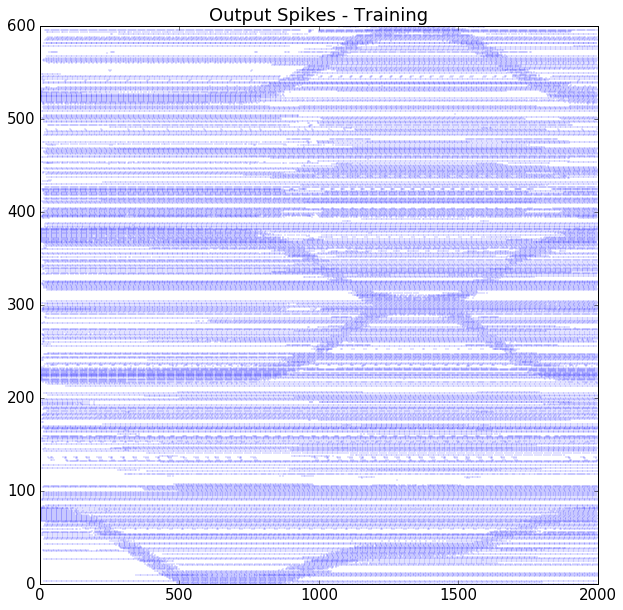

In [104]:
x_plot = numpy.array([t[ti] for i,ti in zip(spikes,xrange(len(spikes))) for j in i])
y_plot = [j for i,ti in zip(spikes,xrange(len(spikes))) for j in i]

plt.figure(figsize=(10,10))
plt.plot(x_plot*1000,y_plot,'.', markersize=.51)#, markevery=100);
# plt.plot(y_plot,'.', markersize=1)#, markevery=100);
# plt.plot(x_plot*1000,y_plot,'.');
plt.xlim(t[0]*1000-1,t[-1]*1000+2);
plt.ylim(0,NofN);
plt.title("Output Spikes - Training");
plt.show();

# This is the simulation to test the readout
# THE READOUT TRAINING MUST BE DONE BEFORE TESTING
# THE TESTS IMPLEMENTED HERE USE ONLY INDIVIDUAL LSMs

In [105]:
# Here it's selected WHICH liquid to use:
# (remember, there are multiple liquids => number_of_liquids)
# lsm_i goes from 0 to (number_of_liquids-1)
lsm_i = 0

liqseeds = slf.load_from_file_gz("./"+base_dir+"/"+sim_set+"/"+"liqseeds.gzpickle")
RANDOM_0,RANDOM_1,RANDOM_2,RANDOM_3,RANDOM_4,_ = liqseeds[lsm_i] # the "_" ignores the input noise seed
RANDOM_1,RANDOM_2,RANDOM_3

(4865, 5606, 394)

In [106]:
# Make sure the coefficients were created to the right size of network...
if disconnected:
    [c_s0,r_s0] = slf.load_from_file("./"+base_dir+"/"+sim_set+"/coefficients_residues_s0_linear_unconnected.pickle")
    [c_s1,r_s1] = slf.load_from_file("./"+base_dir+"/"+sim_set+"/coefficients_residues_s1_linear_unconnected.pickle")
    [c_e1,r_e1] = slf.load_from_file("./"+base_dir+"/"+sim_set+"/coefficients_residues_e1_linear_unconnected.pickle")
    [c_w1,r_w1] = slf.load_from_file("./"+base_dir+"/"+sim_set+"/coefficients_residues_w1_linear_unconnected.pickle")
else:
    [c_s0,r_s0] = slf.load_from_file("./"+base_dir+"/"+sim_set+"/coefficients_residues_s0_linear"+str(lsm_i)+".pickle")
    [c_s1,r_s1] = slf.load_from_file("./"+base_dir+"/"+sim_set+"/coefficients_residues_s1_linear"+str(lsm_i)+".pickle")
    [c_e1,r_e1] = slf.load_from_file("./"+base_dir+"/"+sim_set+"/coefficients_residues_e1_linear"+str(lsm_i)+".pickle")
    [c_w1,r_w1] = slf.load_from_file("./"+base_dir+"/"+sim_set+"/coefficients_residues_w1_linear"+str(lsm_i)+".pickle")    

In [107]:
number_of_joints = 4
number_of_steps = total_steps

# Creates the Ninput possible discrete values of angle for each joint
joints_values=numpy.empty((Ninput,number_of_joints))
for ji in range(number_of_joints):
    joints_values[:,ji]=numpy.linspace(-1,1,Ninput)


joints=numpy.copy(original_joints)

joints.shape

(1000, 4)

In [108]:
bias_vector=slf.load_from_file("./"+base_dir+"/"+sim_set+"/bias_0.pickle")
print (bias_vector).tolist()

[-0.5988172292709351, -0.6402817368507385, 2.042017936706543, 0.20936457812786102]


In [109]:
ranges_vector=slf.load_from_file("./"+base_dir+"/"+sim_set+"/ranges_0.pickle")
print ranges_vector

[0.37046223878860474, 0.14853623509407043, 0.56457579135894775, 0.41667154431343079]


In [110]:
# Resets the simulator
BEE_free()

# Initializes the simulator
tstp = time_step

seeds=numpy.array(numpy.random.randint(0,10000,5),dtype=numpy.uint32)
# // RANDOM-0: Membrane initial potentials
# // RANDOM-1: Noisy offset currents / resets <<<<<<<
# // RANDOM-2: Selection of the inhibitory and excitatory neurons <<<<<<<
# // RANDOM-3: Internal connections of the liquid <<<<<<<
# // RANDOM-4: Noisy corrents
seeds[1] = RANDOM_1
seeds[2] = RANDOM_2
seeds[3] = RANDOM_3

#DEBUG!
# seeds[4] = RANDOM_4
# seeds[0] = RANDOM_0


print "Initializing the simulator..."
if not BEE_initialized():
    %time initialize_sim(my_net_shape = net_shape, \
                         my_lbd_value = lbd_value, \
                         my_seeds=seeds, \
                         SpkLiq_step=tstp,\
                         SpkLiq_threads_N = 5,\
                         SpkLiq_vresets = SpkLiq_vresets_rand,\
                         SpkLiq_membrane_rand=membrane_rand,\
                         SpkLiq_current_rand=current_rand,\
                         SpkLiq_taum=taum, SpkLiq_cm=cm, SpkLiq_taue=taue, SpkLiq_taui=taui, \
                         SpkLiq_noisy_current_rand=noisy_current_rand)

if parameter_list!=[]:
    change_parameters(parameter_list)

generate_connections()

#
# Cancels the connections, but keeps the parameters
#
if disconnected:
    BEE_writes_SpkLiq_inh_connections(0)
    BEE_writes_SpkLiq_exc_connections(0)


process_connections()

print "Verifies..."
NofN,NoINHN,NoEXCN,NoINHC,NoEXCC=output_stats()

# Forces the simulator to calculate the values for all neurons (even the unconnected ones)
# This is important during the tests without connections
control_connected(numpy.ones(NofN,dtype=numpy.int32))

Initializing the simulator...
CPU times: user 392 µs, sys: 544 µs, total: 936 µs
Wall time: 412 µs
Verifies...
Total number of neurons: 600
Number of inhibitory neurons: 120
Number of excitatory neurons: 480
Number of inhibitory connections: 263
Number of excitatory connections: 925


## Below I'm increasing the number of time steps inside the simulation to verify what happens if I force the LSM to generate more outputs than it was trained for.

## So far it seems like a super stable attractor the end of the trajectory.

In [111]:
joints.shape

(1000, 4)

In [112]:
def run_test(using_spikes = 0, membrane_time_constant = 30E-3):
#     using_spikes = 0 #Uses only the spikes without the membrane low-pass filtering
#     membrane_time_constant = 30E-3 #time constant used with the membrane low-pass filter

    # Total time spent during the movement (in seconds)
    MT = 2.0
    # Simulation time step (in seconds)
    time_step = 2/1000.0

    total_steps = int(MT/time_step)

    number_of_steps = total_steps

    # Initializing the simulation...
    seeds=numpy.array(numpy.random.randint(0,10000,5),dtype=numpy.uint32)
    # // RANDOM-0: Membrane initial potentials
    # // RANDOM-1: Noisy offset currents / resets
    # // RANDOM-2: Selection of the inhibitory and excitatory neurons
    # // RANDOM-3: Internal connections of the liquid
    # // RANDOM-4: Noisy corrents
    seeds[1] = RANDOM_1
    seeds[2] = RANDOM_2
    seeds[3] = RANDOM_3

    #DEBUG!
#     seeds[4] = RANDOM_4
#     seeds[0] = RANDOM_0
    

    liquid_soft_reset(seeds) # Resets the simulator
    

    # Initialize the arrays with the simulated values
    # and saves the values for t=0s
    t = []
    spikes = []
    ti=0
#     t.append(ti)
#     spikes.append(reads_spikes(NofN))


    import membrane_lowpass_md
    reload(sys.modules['membrane_lowpass_md']) # Makes sure the interpreter is going to reload the module
    membrane_lowpass = membrane_lowpass_md.membrane_lowpass

    # In this system the initial position is given and the SNN should generate the next ones.
    # These are the values for step=0
    joint_s0=joints[0,0]
    joint_s1=joints[0,1]
    joint_e1=joints[0,2]
    joint_w1=joints[0,3]

    m_v=membrane_lowpass(NofN,membrane_time_constant) # Initialize the membrane

    joint_angles = []
    OutputSpks_save = []
    OutputSpks_Filtered_save = []

    
    # Runs the simulation going step-by-step
    for step_i in range(number_of_steps):

        # Inserting disturbances
#         if 400>step_i>300:
#             joint_s0,joint_s1,joint_e1,joint_w1 = temp*1.02
#         else:
#             temp = numpy.array([joint_s0,joint_s1,joint_e1,joint_w1])

        joint_angles.append([joint_s0,joint_s1,joint_e1,joint_w1])
        
        s0_value = (joint_s0-bias_vector[0])/ranges_vector[0]
        s1_value = (joint_s1-bias_vector[1])/ranges_vector[1]
        e1_value = (joint_e1-bias_vector[2])/ranges_vector[2]
        w1_value = (joint_w1-bias_vector[3])/ranges_vector[3]
        
        input_spikes = [abs(joints_values[:,0]-s0_value).argmin(),\
                        abs(joints_values[:,1]-s1_value).argmin(),\
                        abs(joints_values[:,2]-e1_value).argmin(),\
                        abs(joints_values[:,3]-w1_value).argmin()]

        exc_inputs = numpy.concatenate([numpy.array(inputs_indices[input_variable][ni]) for input_variable,ni in zip(range(len(input_spikes)),input_spikes)])
        inh_inputs = []
        exc_weights =  numpy.concatenate([numpy.array(inputs_weights[input_variable][ni]) for input_variable,ni in zip(range(len(input_spikes)),input_spikes)])
        inh_weights = []

        # Here the simulator is receiving the input spikes (and returning the output ones):
        # r, current_t, received_spikes, OutputSpks, t = s.run_step(input_spikes) # Sends the spikes and reads the output
        updates_sim(exc_inputs, inh_inputs, exc_weights*1E-9, inh_weights, len(exc_inputs), 0)

        # Appends to the output
        t.append(ti)
        spikes.append(reads_spikes(NofN))
        ti+=tstp
        
        OutputSpks = spikes[-1]

        if using_spikes:
            Output = numpy.zeros(NofN); Output[OutputSpks]=1 # Using the output of the liquid directly
        else:
            m_v.process_spikes(OutputSpks,ti) # Send the spikes to the membrane filter
            OutputSpks_Filtered = m_v.check_values(ti) # Reads the values of the membranes
            OutputSpks_Filtered_save.append(OutputSpks_Filtered)        
            Output = OutputSpks_Filtered # Using the low-pass (membrane) filtered version of the liquid's output
        
        joint_s0=(bias_vector[0]+(Output.dot(c_s0)+r_s0)*ranges_vector[0]) # Calculates the joint angles from the membrane filtered values
        joint_s1=(bias_vector[1]+(Output.dot(c_s1)+r_s1)*ranges_vector[1]) # Calculates the joint angles from the membrane filtered values
        joint_e1=(bias_vector[2]+(Output.dot(c_e1)+r_e1)*ranges_vector[2]) # Calculates the joint angles from the membrane filtered values
        joint_w1=(bias_vector[3]+(Output.dot(c_w1)+r_w1)*ranges_vector[3]) # Calculates the joint angles from the membrane filtered values    
            

    return t, spikes, joint_angles

In [113]:
%%time

number_of_trials=10

t_batch=[]
spikes_batch=[]
joint_batch=[]
for i in range(number_of_trials):
    t, spikes, joint_angles=run_test()
    t_batch.append(t)
    spikes_batch.append(spikes)
    joint_batch.append(joint_angles)
    

CPU times: user 3.51 s, sys: 3.84 s, total: 7.34 s
Wall time: 4.8 s


In [114]:
spikes_batch[0][:5]

[array([], dtype=int32),
 array([ 69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  82,
        219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231,
        232, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 518,
        520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531], dtype=int32),
 array([ 67,  68,  81, 218, 368, 369, 381, 519, 532], dtype=int32),
 array([ 53,  55,  59,  83,  90,  91, 124, 154, 156, 157, 168, 174, 177,
        181, 192, 194, 195, 198, 217, 219, 220, 223, 225, 226, 227, 229,
        230, 231, 241, 243, 258, 293, 296, 302, 322, 323, 333, 341, 343,
        356, 366, 370, 372, 377, 380, 394, 395, 396, 400, 430, 442, 454,
        459, 501, 508, 514, 518, 529, 543, 545, 548], dtype=int32),
 array([ 66,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,
         81,  82, 221, 222, 224, 228, 232, 269, 280, 351, 360, 367, 368,
        371, 373, 374, 375, 376, 378, 379, 382, 412, 425, 469, 517, 520,
        521, 522, 523, 524

In [115]:
total_spikes = len(numpy.concatenate(spikes))
print "Total number of spikes:",total_spikes

Total number of spikes: 108194


In [116]:
number_of_steps = total_steps
print "Total Number of Spikes Generated:%d\nTotal Number of Neurons:%d\nFigure Spike Density(%%):%f"%(total_spikes,NofN*number_of_steps,100*total_spikes/float(NofN*number_of_steps))

Total Number of Spikes Generated:108194
Total Number of Neurons:600000
Figure Spike Density(%):18.032333


In [117]:
joint_mean=numpy.array(joint_batch).mean(axis=0)
joint_stderr=numpy.array(joint_batch).std(axis=0)/numpy.sqrt(len(joint_batch[0]))

In [118]:
simulation_results = numpy.array(joint_batch)

In [119]:
# Saves the calculated joints
if save2file:
    slf.save_to_file(simulation_results,base_dir+"/"+sim_set+"/joint_batch_0.pickles")

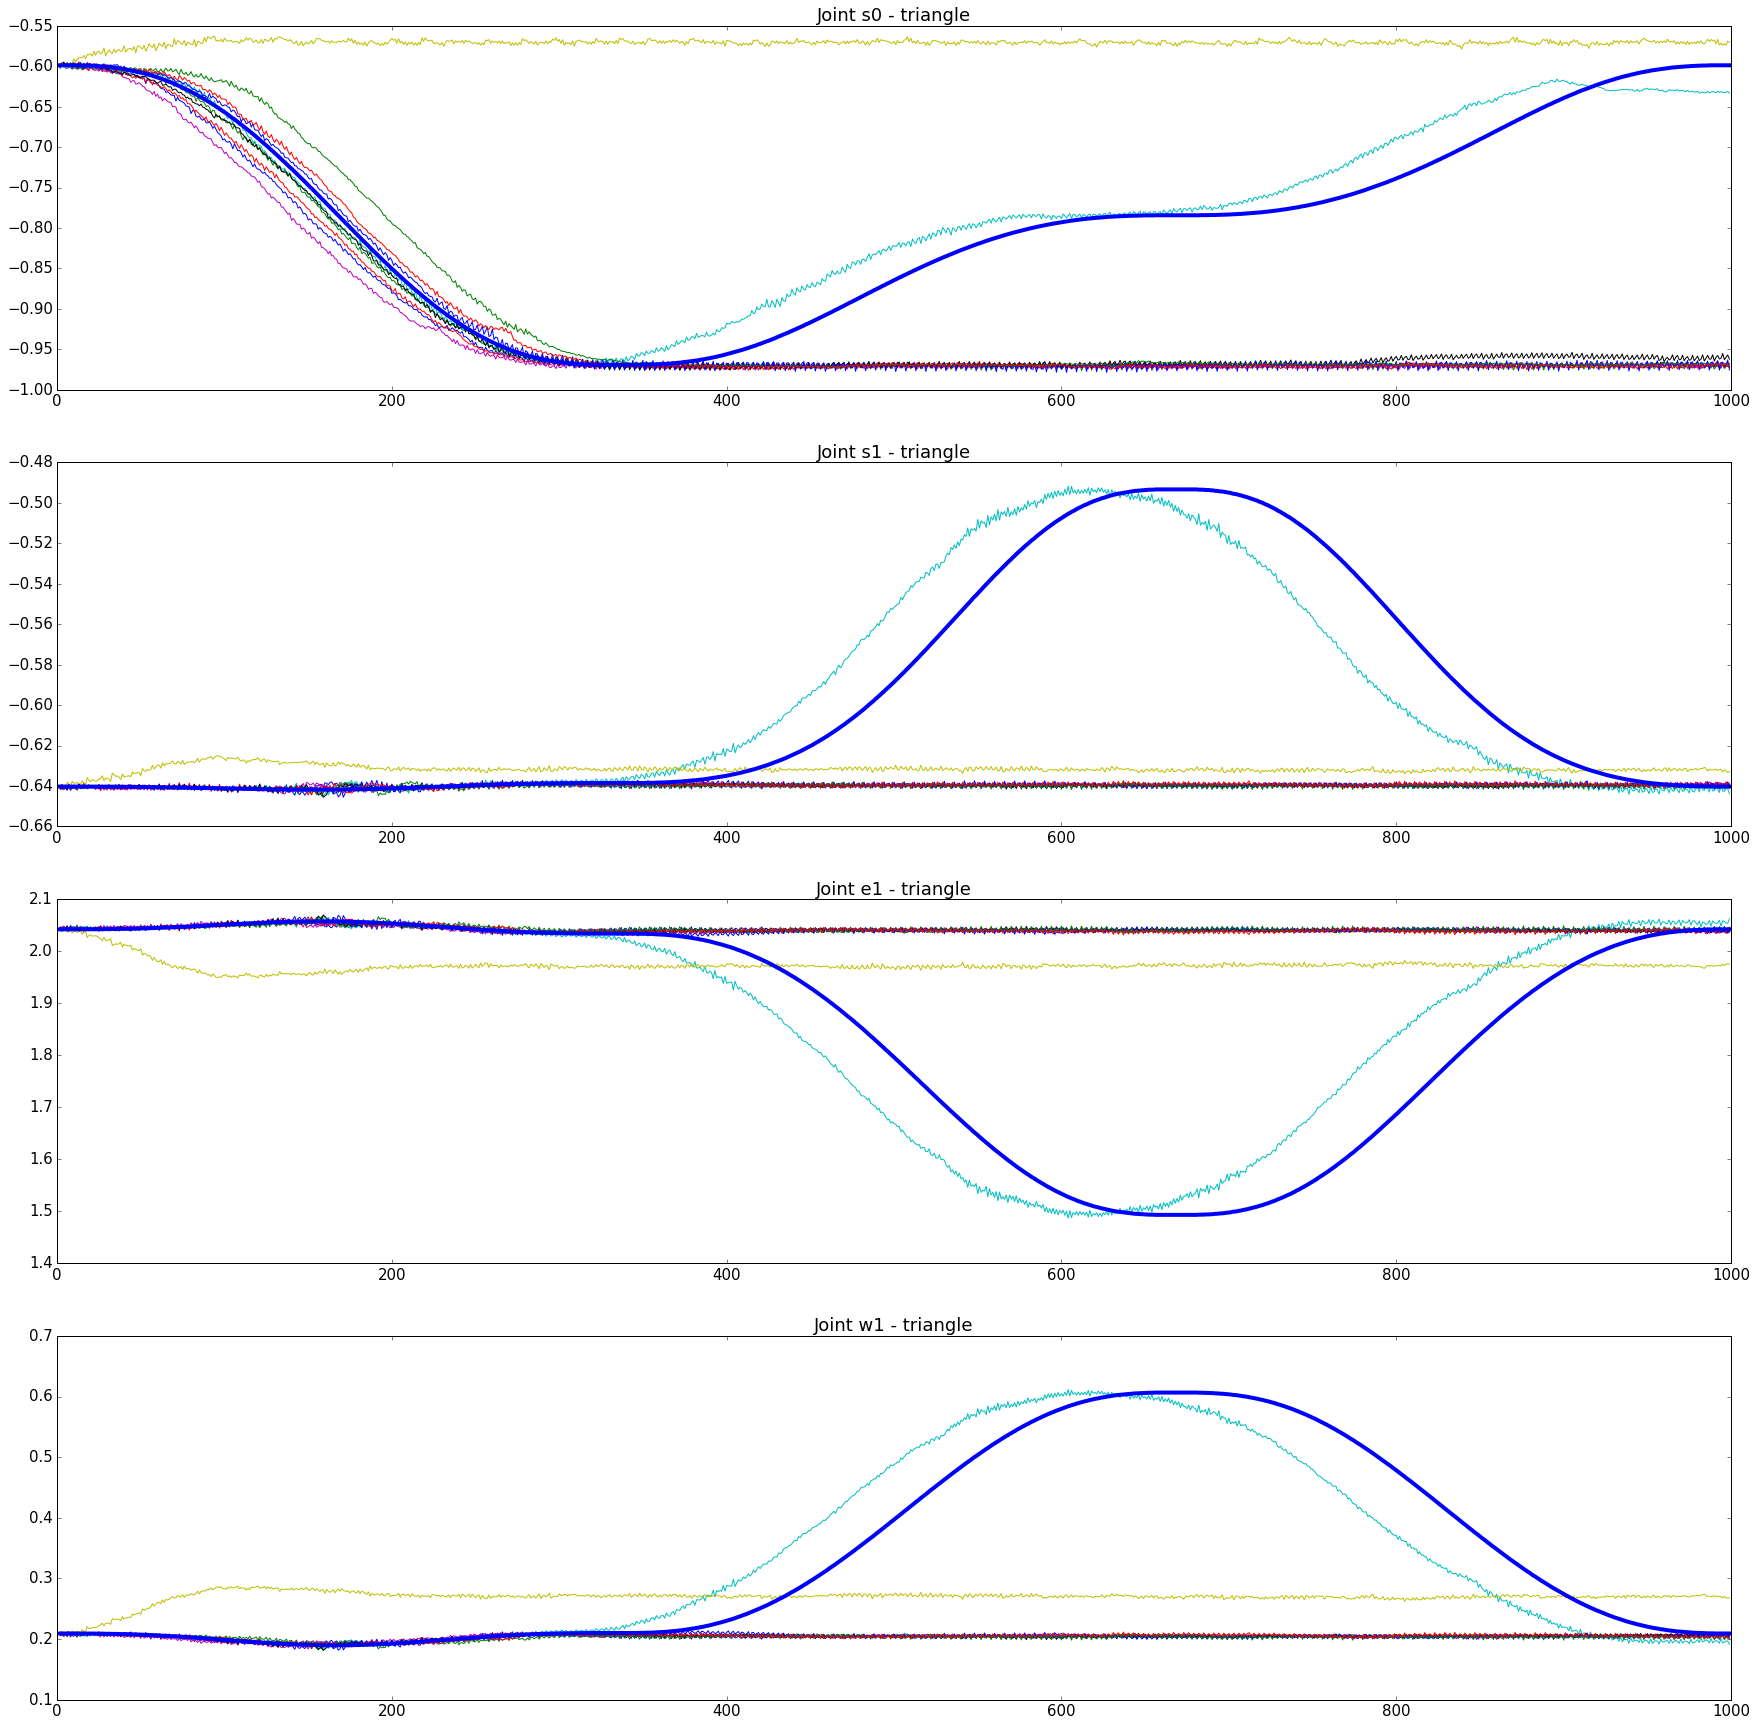

In [120]:
joint_names = ["s0","s1","e1","w1"]
plt.figure(figsize =(30,30))
for ji in range(4):
    plt.subplot(411+ji)
    for run_number in range(simulation_results.shape[0]):  
        plt.plot((simulation_results[run_number])[:,ji],'-',label="Calculated")
    plt.plot(joints[:,ji],'b-',linewidth=4,label="Original")
    plt.title("Joint "+joint_names[ji] + " - " + sim_set)

plt.show()

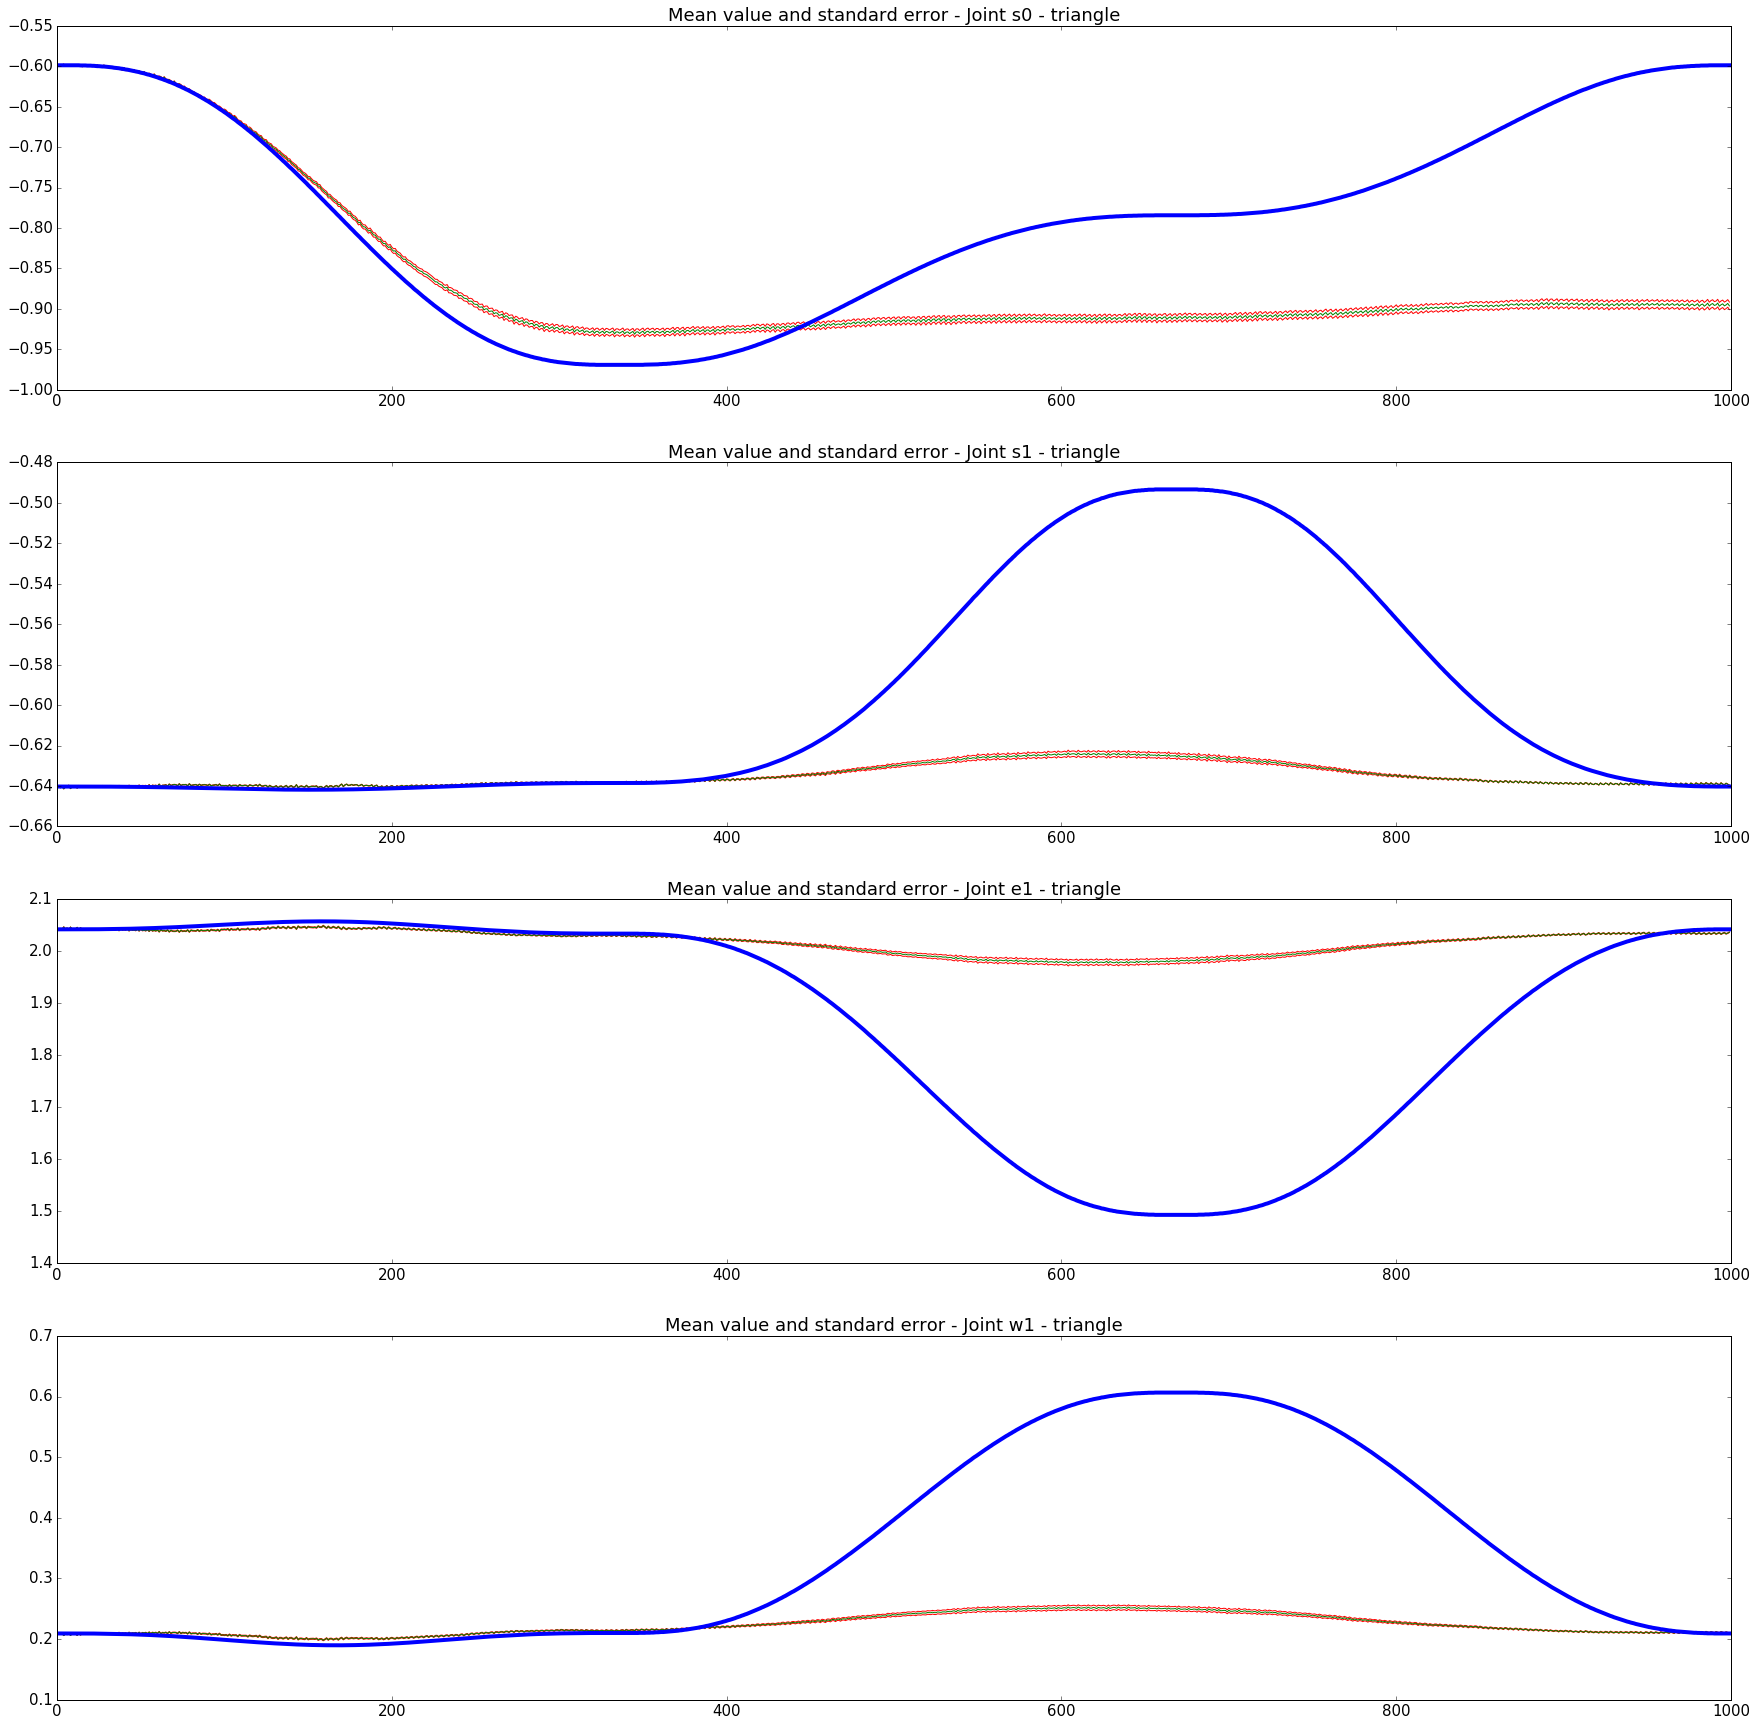

In [121]:
plt.figure(figsize =(30,30))
for ji in range(4):
    plt.subplot(411+ji)
    plt.plot(joint_mean[:,ji]+joint_stderr[:,ji],'r-')
    plt.plot(joint_mean[:,ji]-joint_stderr[:,ji],'r-')
    plt.plot(joint_mean[:,ji],'g-')
    plt.plot(joints[:,ji],'b-',linewidth=4)
    plt.title("Mean value and standard error - Joint "+joint_names[ji]  + " - " + sim_set)
plt.show()

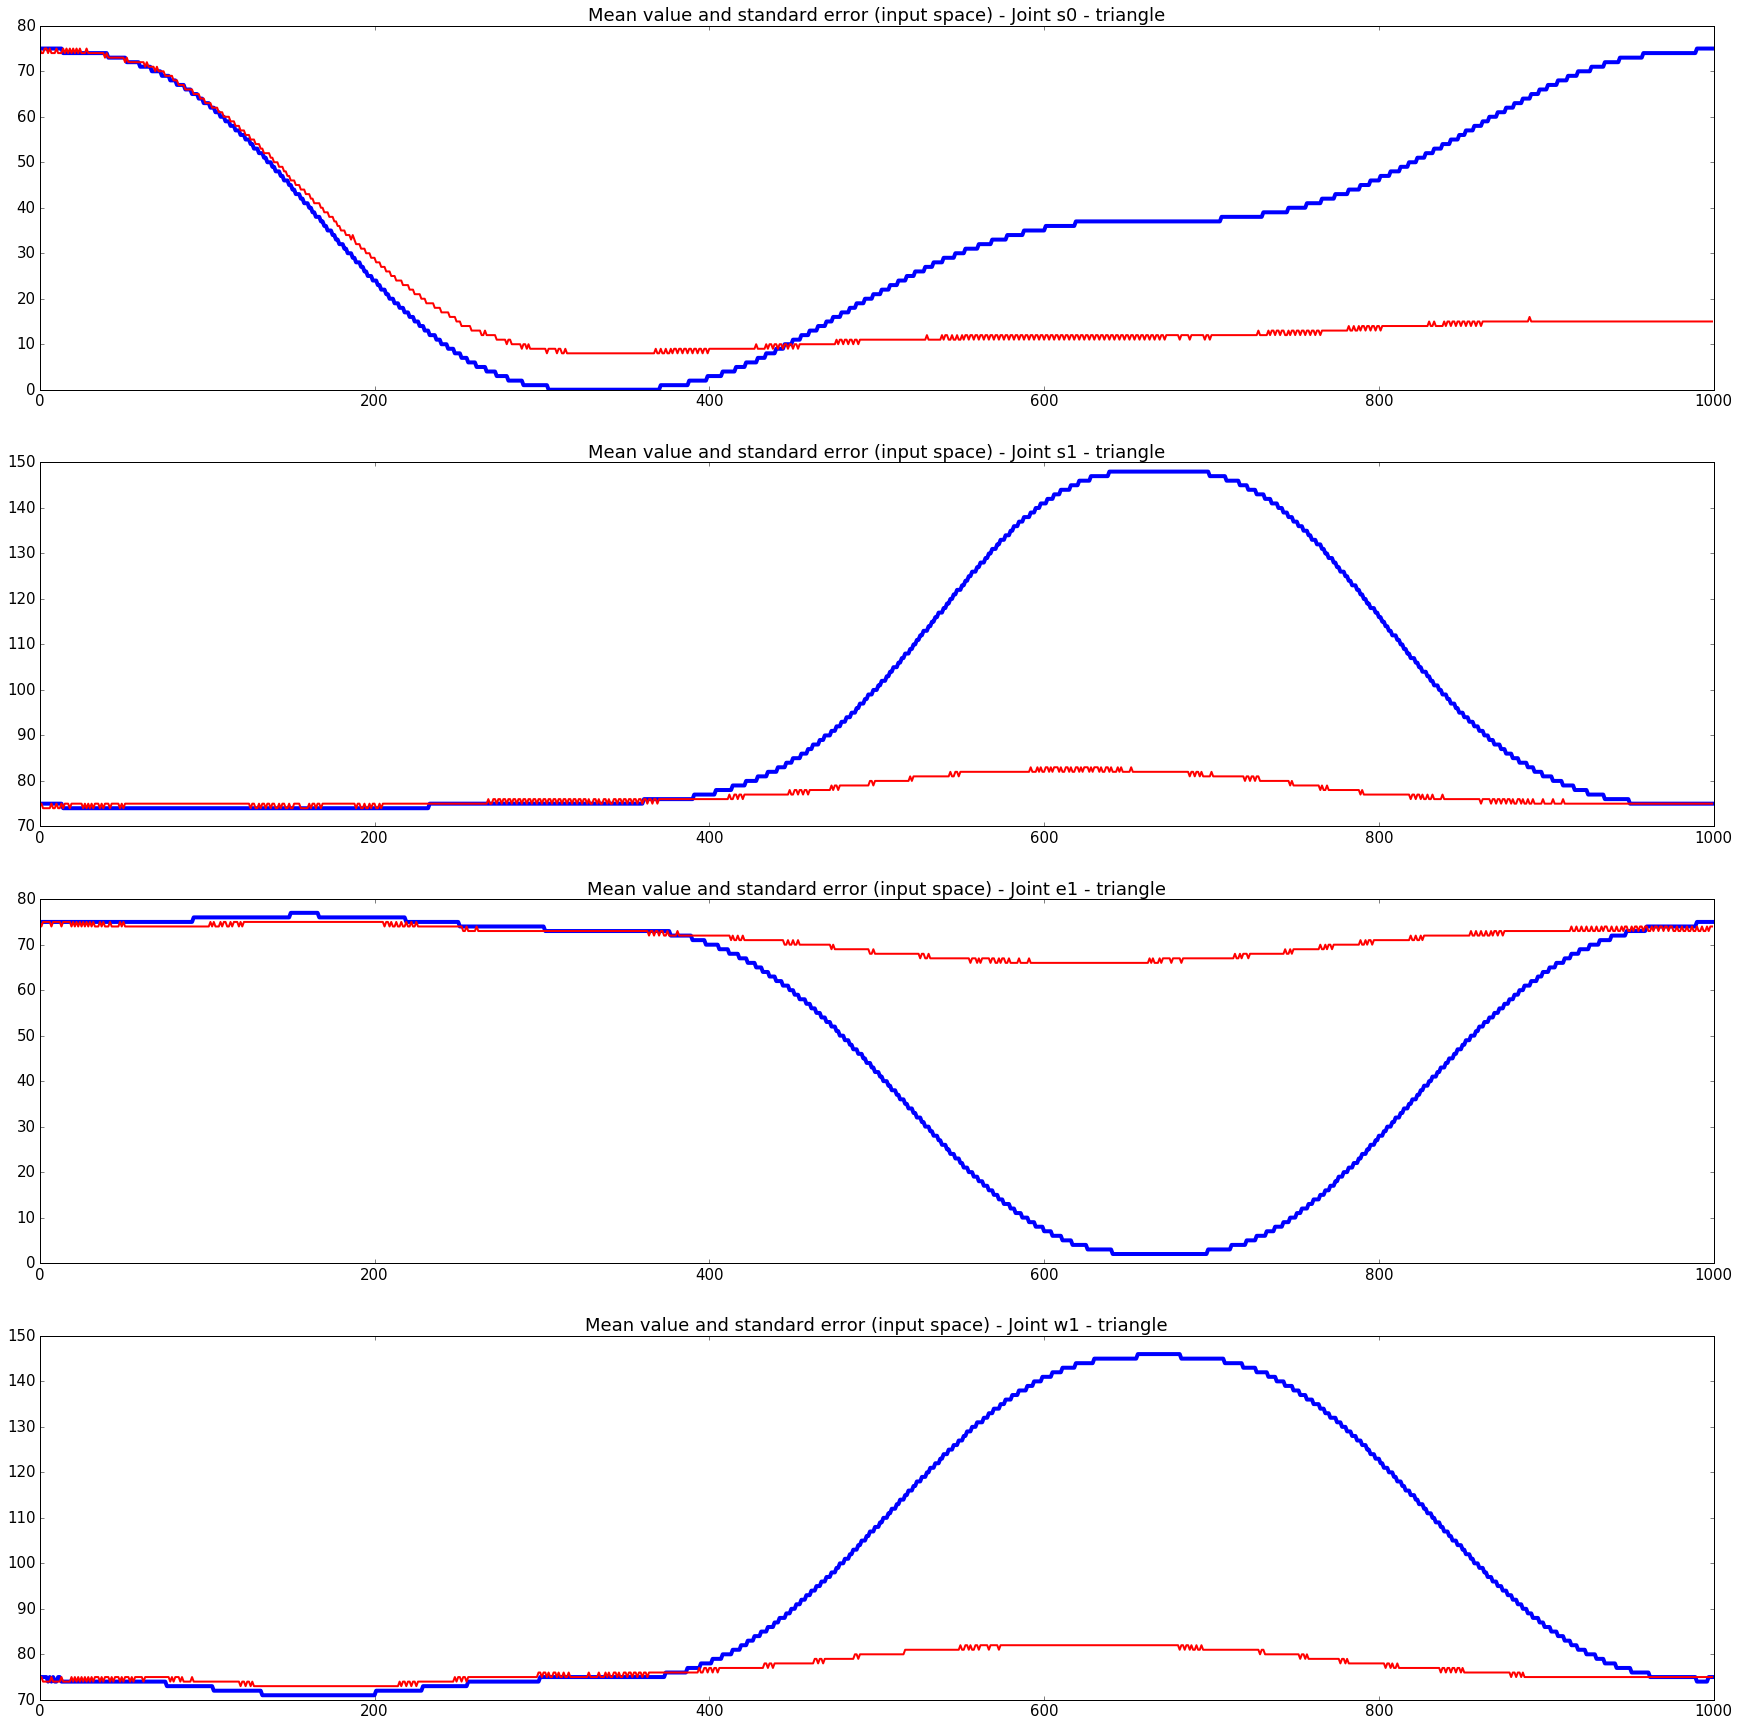

In [122]:
rgs = ranges_vector

plt.figure(figsize =(30,30))
for ji in range(4):
    plt.subplot(411+ji)
    plt.plot([abs(joints_values[:,ji]-(i-bias_vector[ji])/rgs[ji]).argmin() for i in joints[:,ji]],'b-',linewidth=4)
    plt.plot([abs(joints_values[:,ji]-(i-bias_vector[ji])/rgs[ji]).argmin() for i in joint_mean[:,ji]],'r-',linewidth=2)
    plt.title("Mean value and standard error (input space) - Joint "+joint_names[ji]  + " - " + sim_set)
plt.show()



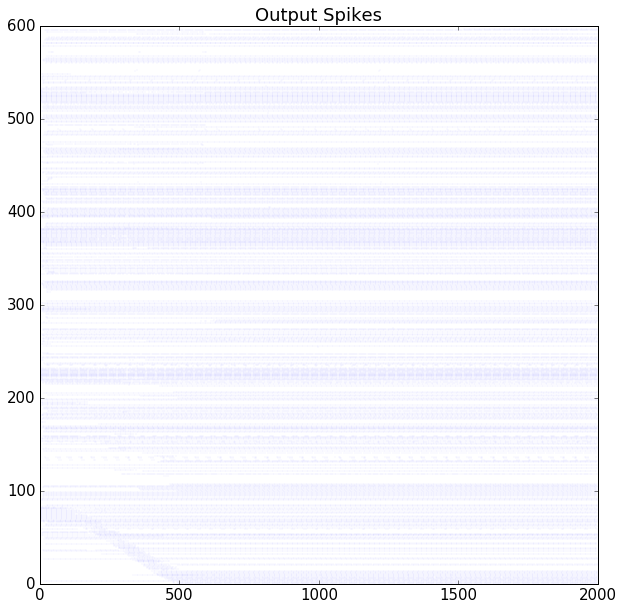

In [123]:
run_number=1

spikes=spikes_batch[run_number]
x_plot = numpy.array([t[ti] for i,ti in zip(spikes,xrange(len(spikes))) for j in i])
y_plot = [j for i,ti in zip(spikes,xrange(len(spikes))) for j in i]

plt.figure(figsize=(10,10))
plt.plot(x_plot*1000,y_plot,'.', markersize=.1)#, markevery=100);
# plt.plot(x_plot*1000,y_plot,'.');
plt.xlim(t[0]*1000-1,t[-1]*1000+1);
plt.ylim(0,NofN);
plt.title("Output Spikes");
plt.show();